In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
from keras import layers
import numpy as np
import xarray as xr
import zarr
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import random
import jax
import tensorflow as tf
from tqdm import tqdm
import jax.numpy as jnp
from jax import grad, jit, vmap
from utils.clim_loss_vit import custom_loss
#from utils.clim_loss import ClimateDownscalingLoss

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
jax.config.update('jax_enable_x64', True)
jax.random.PRNGKey(SEED)


# Set the working directory
os.chdir('/data/keeling/a/ad87/downscale')

2024-12-02 10:09:25.446689: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Data Handling: Load and Resample Data
We will load the CMIP6 data and the GMFD observational data. We’ll resample the GMFD data to the CMIP6 resolution (e.g., ~100 km) to use as the target during training.



In [2]:
# Load the CMIP6 raw data (predictor variables)
cmip6_data_path = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_data = xr.open_zarr(cmip6_data_path)

cmip6_psl_path = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_psl = xr.open_zarr(cmip6_psl_path)

# Load the GMFD reference observational data (target variable)
gmfd_data_path = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro'
gmfd_files = [f'{gmfd_data_path}/tas_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_data = xr.open_mfdataset(gmfd_files, combine='by_coords')

# Resample  CMIP6 to GMFD resolution (~25 km)
target_lat = gmfd_data.lat
target_lon = gmfd_data.lon
cmip6_high_res = cmip6_data.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_high_psl = cmip6_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})

def normalize(data):
    min_val = data.min()
    max_val = data.max()
    return (data - min_val) / (max_val - min_val)

cmip6_data_norm = normalize(cmip6_high_res['tas'])
cmip6_psl_norm = normalize(cmip6_high_psl['psl'])
gmfd_data_norm = normalize(gmfd_data['tas'])


# Convert data to NumPy arrays for use in Keras
cmip6_train = cmip6_data_norm.values
cmip6_train_psl = cmip6_psl_norm.values
gmfd_train = gmfd_data_norm.values

#### Compute residuals

In [3]:
import xarray as xr

# Assuming gmfd_data and cmip6_high_res are xarray Datasets or DataArrays

# 1. Time Alignment: Normalize cmip6_high_res time to date only
cmip6_data_norm['time'] = cmip6_data_norm['time'].dt.floor('D')
residuals = gmfd_data_norm  - cmip6_data_norm

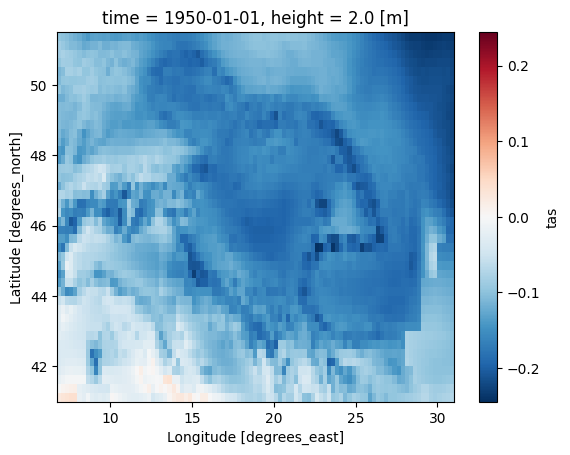

In [4]:
residuals.isel(time=0).plot()

#### Build the VIT-transformenrs (Keras with JAX Backend)


In [5]:
from keras import ops
from keras.layers import (
    Input, Dense, Dropout, MultiHeadAttention, LayerNormalization,
    Add, Conv2D, Reshape, Flatten, Lambda, Layer
)
from keras.models import Model
from keras import Sequential
import numpy as np
from keras.saving import register_keras_serializable

# **Learnable Positional Encoding Layer**
@register_keras_serializable()  # Register this layer with Keras
class LearnablePositionalEncoding(Layer):
    def __init__(self, seq_len, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.embed_dim = embed_dim

    def build(self, input_shape):
        # Learnable positional embedding
        self.pos_embedding = self.add_weight(
            shape=(1, self.seq_len, self.embed_dim),
            initializer="random_normal",
            trainable=True,
            name="positional_embedding"
        )

    def call(self, inputs):
        return inputs + self.pos_embedding

    def get_config(self):
        config = super().get_config()
        config.update({"seq_len": self.seq_len, "embed_dim": self.embed_dim})
        return config


# **Residual Multi-Scale Patch Embedding Layer**
@register_keras_serializable()  # Register this layer with Keras
class ResidualMultiScalePatchEmbedding(Layer):
    def __init__(self, patch_size, embed_dim, num_scales=3, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_scales = num_scales

    def build(self, input_shape):
        # Multi-scale convolutions
        self.convs = [
            Conv2D(
                filters=self.embed_dim // self.num_scales,
                kernel_size=(k, k),
                strides=self.patch_size[1:],
                padding='same',
                name=f"scale_{k}x{k}"
            )
            for k in range(3, 3 + self.num_scales)
        ]
        self.fusion = Conv2D(
            filters=self.embed_dim,
            kernel_size=1,
            strides=1,
            padding="same",
            name="multi_scale_fusion"
        )
        # Residual projection
        self.residual_proj = Conv2D(
            filters=self.embed_dim,
            kernel_size=1,
            strides=self.patch_size[1:],  # Match the patch strides
            padding="same",
            name="residual_projection"
        )

    def call(self, x):
        batch_size = ops.shape(x)[0]
        x_reshaped = ops.reshape(x, (-1, ops.shape(x)[2], ops.shape(x)[3], ops.shape(x)[4]))

        # Multi-scale feature extraction
        multi_scale_features = [conv(x_reshaped) for conv in self.convs]
        combined_features = ops.concatenate(multi_scale_features, axis=-1)

        # Fuse features
        fused_features = self.fusion(combined_features)

        # Residual connection
        residual = self.residual_proj(x_reshaped)
        fused_features += residual  # Add residual path

        # Flatten to patch embeddings
        _, h, w, c = ops.shape(fused_features)
        return ops.reshape(fused_features, (batch_size, h * w, c))

    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
            "embed_dim": self.embed_dim,
            "num_scales": self.num_scales
        })
        return config


# **Transformer Block**
@register_keras_serializable()  # Register this layer with Keras
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.attention = MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.embed_dim // self.num_heads,
            dropout=self.dropout
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.mlp = Sequential([
            Dense(self.mlp_dim, activation="gelu"),
            Dropout(self.dropout),
            Dense(self.embed_dim),
            Dropout(self.dropout)
        ])

    def call(self, inputs):
        # Multi-head attention
        attn_output = self.attention(inputs, inputs)
        x = Add()([inputs, attn_output])
        x = self.layernorm1(x)

        # Feed-forward network
        mlp_output = self.mlp(x)
        return self.layernorm2(Add()([x, mlp_output]))

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "mlp_dim": self.mlp_dim,
            "dropout": self.dropout
        })
        return config


    

# **Vision Transformer Model**
def vit_transformer(input_shape, patch_size, embed_dim, num_heads, transformer_layers, mlp_dim, dropout):
    inputs = Input(shape=input_shape)

    # Residual Multi-Scale Patch Embedding
    x = ResidualMultiScalePatchEmbedding(patch_size=patch_size, embed_dim=embed_dim, num_scales=3)(inputs)

    # Add learnable positional encoding
    x = LearnablePositionalEncoding(seq_len=x.shape[1], embed_dim=embed_dim)(x)

    # Transformer layers
    for _ in range(transformer_layers):
        x = TransformerBlock(embed_dim=embed_dim, num_heads=num_heads, mlp_dim=mlp_dim, dropout=dropout)(x)

    # Fully connected layers for regression
    x = Flatten()(x)
    x = Dense(units=mlp_dim, activation="gelu")(x)
    x = Dropout(dropout)(x)

    # Final dense layer with the total number of required units
    total_units = 1 * 42 * 97 * 1  # Calculate the total number of elements in the output
    x = Dense(units=total_units, activation="linear")(x)

    # Reshape to match the target output shape
    outputs = Reshape(target_shape=(1, 42, 97, 1))(x)

    return Model(inputs, outputs)

# # **Example Usage**
# input_shape = (1, 42, 97, 2)  # Temporal=1, Spatial=42x97, 2 channels
# patch_size = (1, 6, 7)  # Temporal=1, Spatial=6x7

# model = vit_transformer(
#     input_shape=input_shape,
#     patch_size=patch_size,
#     embed_dim=220,
#     num_heads=4,
#     transformer_layers=4,
#     mlp_dim=128,
#     dropout=0.1
# )

# model.summary()





#### Split the data
Train set: The first portion of the time period (e.g., 60% of the time series).
Validation set: The next portion of the time series (e.g., the following 20% of the time series).
Test set: The final portion of the time series (e.g., the last 20%): 

In [6]:
import pandas as pd
index_2004 = int(np.where(cmip6_data_norm.time.values == pd.to_datetime('2004-12-31'))[0][0])
index_2009 = int(np.where(cmip6_data_norm.time.values == pd.to_datetime('2009-12-31'))[0][0])

In [7]:
# Reshape data to add the channel dimension
cmip6_train_reshaped = cmip6_train[..., np.newaxis]
cmip6_train_slp_reshaped = cmip6_train_psl[..., np.newaxis]

# Concatenate the reshaped arrays along the last axis
cmip6_train_combined = np.concatenate((cmip6_train_reshaped, cmip6_train_slp_reshaped), axis=-1)

gmfd_train_reshaped = gmfd_train[..., np.newaxis]
residual_reshaped = residuals.values[..., np.newaxis]

# Split the data while preserving the temporal structure
X_train = cmip6_train_combined[:index_2004]
y_train = gmfd_train_reshaped[:index_2004]
res_train = residual_reshaped[:index_2004]

X_val = cmip6_train_combined[index_2004:index_2009]
y_val = gmfd_train_reshaped[index_2004:index_2009]
res_val =  residual_reshaped[index_2004:index_2009]

X_test = cmip6_train_combined[index_2009:]
y_test = gmfd_train_reshaped[index_2009:]
res_test = residual_reshaped[index_2009:]


# Reshape X data to include the temporal dimension
X_train = np.expand_dims(X_train, axis=1)
X_val = np.expand_dims(X_val, axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Reshape y data to include the temporal dimension
y_train = np.expand_dims(y_train, axis=1)
y_val = np.expand_dims(y_val, axis=1)
y_test = np.expand_dims(y_test, axis=1)

# Reshape y data to include the temporal dimension
res_train = np.expand_dims(res_train, axis=1)
res_val = np.expand_dims(res_val, axis=1)
res_test = np.expand_dims(res_test, axis=1)


In [8]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(res_train.shape)
print(res_val.shape)
print(res_test.shape)

(20088, 1, 42, 97, 2)
(1826, 1, 42, 97, 2)
(1827, 1, 42, 97, 2)
(20088, 1, 42, 97, 1)
(1826, 1, 42, 97, 1)
(1827, 1, 42, 97, 1)


#### Train the model

In [112]:
from keras import ops
from keras.losses import Loss
from keras.saving import register_keras_serializable

@register_keras_serializable()
class ClimateDownscalingLoss(Loss):
    def __init__(self, spatial_weight=1.0, gradient_weight=0.5, **kwargs):
        super().__init__(**kwargs)
        self.spatial_weight = spatial_weight
        self.gradient_weight = gradient_weight

    def call(self, y_true, y_pred):
        # 1. Mean Squared Error (base loss)
        mse_loss = ops.mean(ops.square(y_true - y_pred))

        # 2. Spatial Gradient Loss
        def spatial_gradients(x):
            # Calculate gradients in both spatial dimensions
            dy = x[:, :, 1:, :, :] - x[:, :, :-1, :, :]
            dx = x[:, :, :, 1:, :] - x[:, :, :, :-1, :]
            return dy, dx

        true_dy, true_dx = spatial_gradients(y_true)
        pred_dy, pred_dx = spatial_gradients(y_pred)
        
        gradient_loss = (ops.mean(ops.square(true_dy - pred_dy)) + 
                        ops.mean(ops.square(true_dx - pred_dx)))

        # Combine losses
        total_loss = (self.spatial_weight * mse_loss + 
                     self.gradient_weight * gradient_loss)
        
        return total_loss

    def get_config(self):
        config = super().get_config()
        config.update({
            "spatial_weight": self.spatial_weight,
            "gradient_weight": self.gradient_weight
        })
        return config

In [113]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from keras import ops

input_shape = (1, 42, 97, 2)  # Temporal=1, Spatial=42x97, 2 channels
patch_size = (1, 3, 3)  # Temporal=1, Spatial=6x7

model = vit_transformer(
    input_shape=input_shape,
    patch_size=patch_size,
    embed_dim=320,
    num_heads=8,
    transformer_layers=8,
    mlp_dim=512,
    dropout=0.1
)

# Training configuration
epochs = 500
batch_size = 100

# Optimizer with learning rate schedule (ReduceLROnPlateau will handle adjustments)
optimizer = keras.optimizers.Adam(
    learning_rate=1e-3,  # Starting learning rate
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    clipnorm=1.0
)

# Create an instance of the loss function
climate_loss = ClimateDownscalingLoss(
    spatial_weight=1.0,    # Weight for MSE loss
    gradient_weight=0.5    # Weight for gradient loss
)


# Compile model
model.compile(
    optimizer=optimizer,
    loss=climate_loss,
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)


# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        min_delta=1e-4
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='models/vit_transformer_best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    ),
    keras.callbacks.TerminateOnNaN()
]

# Training
history = model.fit(
    X_train, res_train,
    validation_data=(X_val, res_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1,  # Display progress per epoch
    shuffle=False  # Sequential data training
)

# Summarize results
print("\nTraining completed.")
best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss) + 1
print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")


Epoch 1/500
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 62.4802 - mean_absolute_error: 0.8701 - root_mean_squared_error: 3.9112
Epoch 1: val_loss improved from inf to 0.00714, saving model to models/vit_transformer_best_model.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 91s 393ms/step - loss: 62.2421 - mean_absolute_error: 0.8671 - root_mean_squared_error: 3.9027 - val_loss: 0.0071 - val_mean_absolute_error: 0.0648 - val_root_mean_squared_error: 0.0827 - learning_rate: 0.0010
Epoch 2/500
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0069 - mean_absolute_error: 0.0629 - root_mean_squared_error: 0.0813
Epoch 2: val_loss improved from 0.00714 to 0.00688, saving model to models/vit_transformer_best_model.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 59s 252ms/step - loss: 0.0069 - mean_absolute_error: 0.0629 - root_mean_squared_error: 0.0813 - val_loss: 0.0069 - val_mean_absolute_error: 0.0639 - val_root_mean_squared_error: 0.0817 - learning_rate: 0.0010
Epoch 3/500
201/201 ━━━━━━━━━━━━━━━━━━━━ 0

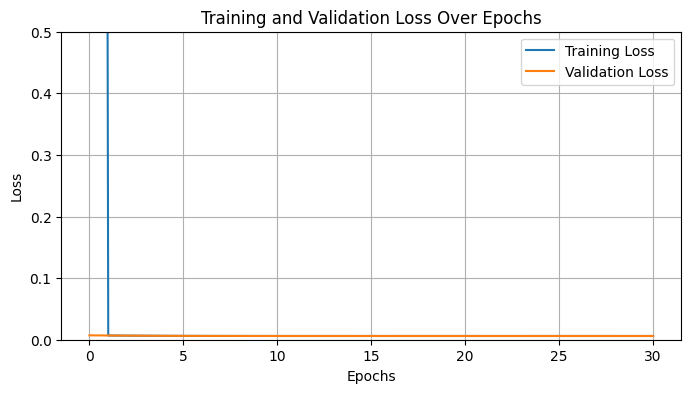

In [114]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of model.fit()
plt.figure(figsize=(8, 4))

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Title and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Optional: Set y-axis limits
plt.ylim(0, 0.5)

# Show legend
plt.legend()

# Add grid for clarity
plt.grid()

# Show the plot
plt.show()


#### Evaluate the model on validation data

In [115]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Load the model

from keras.models import load_model

model_best = load_model('models/vit_transformer_best_model.keras')

# Get the mean and std from the training set for denormalization
cmip6_high_res_min = cmip6_high_res['tas'].min().values
cmip6_high_res_max = cmip6_high_res['tas'].max().values

# Get the mean and std from the training set for denormalization
gmfd_min = gmfd_data['tas'].min().values
gmfd_max = gmfd_data['tas'].max().values


# Generate predictions on validation data
y_pred = model_best.predict(X_test)
print(y_pred.shape)
print(y_val.shape)
print(y_test.shape)

58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step
(1827, 1, 42, 97, 1)
(1826, 1, 42, 97, 1)
(1827, 1, 42, 97, 1)


In [116]:
# put back the residuals
y_pred = X_test[:,0,:,:,0] +  y_pred[:,0,:,:,0]
print(y_pred.shape)
print(y_test.shape)



(1827, 42, 97)
(1827, 1, 42, 97, 1)


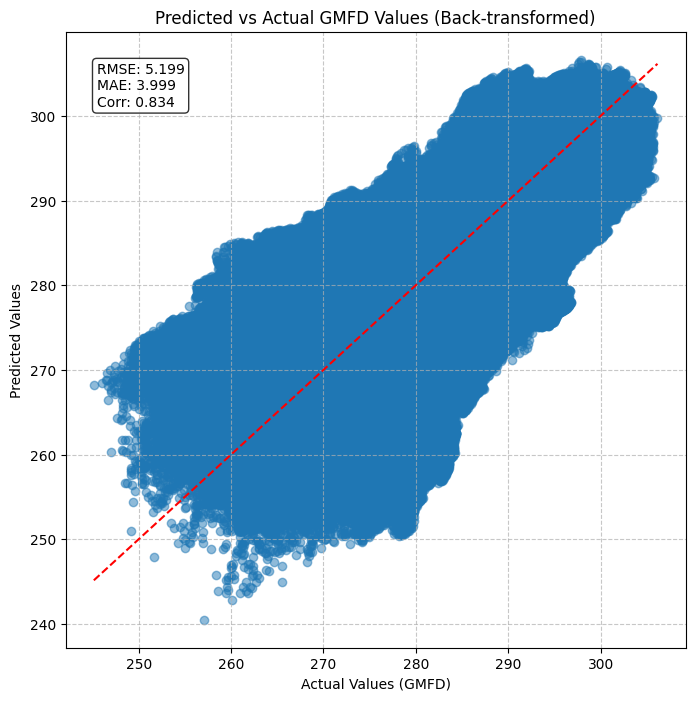

In [117]:
# Back-transform the predictions for evaluation
y_test_denorm = y_test[:,0,:,:,0] * (gmfd_max - gmfd_min) + gmfd_min
y_pred_denorm = y_pred * (cmip6_high_res_max - cmip6_high_res_min) + cmip6_high_res_min


# Calculate RMSE, MAE, and correlation
rmse = np.sqrt(mean_squared_error(y_test_denorm.flatten(), y_pred_denorm.flatten()))
mae = mean_absolute_error(y_test_denorm.flatten(), y_pred_denorm.flatten())
correlation = np.corrcoef(y_test_denorm.flatten(), y_pred_denorm.flatten())[0,1]

# Create the plot
plt.figure(figsize=(8, 8))
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid
plt.scatter(y_test_denorm.flatten(), y_pred_denorm.flatten(), alpha=0.5)
plt.xlabel('Actual Values (GMFD)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual GMFD Values (Back-transformed)')
plt.plot([y_test_denorm.min(), y_test_denorm.max()], 
         [y_test_denorm.min(), y_test_denorm.max()], 'r--')

# Add RMSE, MAE, and correlation text to the upper left
plt.text(0.05, 0.95, f'RMSE: {rmse:.3f}\nMAE: {mae:.3f}\nCorr: {correlation:.3f}',  
         transform=plt.gca().transAxes, 
         verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

#### Train the on All Data
Train the model on all the data (no splitting)

In [15]:
X_all = np.concatenate((X_train, X_val, X_test), axis=0)
y_all = np.concatenate((y_train, y_val, y_test), axis=0)
res_all = np.concatenate((res_train, res_val, res_test), axis=0)

In [130]:
input_shape = (1, 42, 97, 2)  # Temporal=1, Spatial=42x97, 2 channels
patch_size = (1, 3, 3)  # Temporal=1, Spatial=6x7

model = vit_transformer(
    input_shape=input_shape,
    patch_size=patch_size,
    embed_dim=320,
    num_heads=8,
    transformer_layers=8,
    mlp_dim=512,
    dropout=0.1
)

# Training configuration
epochs = 500
batch_size = 100

# Optimizer with learning rate schedule (ReduceLROnPlateau will handle adjustments)
optimizer = keras.optimizers.Adam(
    learning_rate=1e-3,  # Starting learning rate
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    clipnorm=1.0
)



# Compile model
model.compile(
    optimizer=optimizer,
    loss=climate_loss,
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        min_delta=1e-4
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='models/vit_transformer_final_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    ),
    keras.callbacks.TerminateOnNaN()
]

# Retrain the model using the predefined validation set
history = model.fit(
    X_all, res_all,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1,
    shuffle=False,
    validation_split = 0.2
)
# Summarize results
print("\nTraining completed.")
best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss) + 1
print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")


Epoch 1/500
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - loss: 73.6260 - mean_absolute_error: 1.1785 - root_mean_squared_error: 4.3617
Epoch 1: val_loss improved from inf to 0.00712, saving model to models/vit_transformer_final_model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 89s 420ms/step - loss: 73.3378 - mean_absolute_error: 1.1741 - root_mean_squared_error: 4.3519 - val_loss: 0.0071 - val_mean_absolute_error: 0.0646 - val_root_mean_squared_error: 0.0824 - learning_rate: 0.0010
Epoch 2/500
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.0069 - mean_absolute_error: 0.0631 - root_mean_squared_error: 0.0815
Epoch 2: val_loss improved from 0.00712 to 0.00691, saving model to models/vit_transformer_final_model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 58s 263ms/step - loss: 0.0069 - mean_absolute_error: 0.0631 - root_mean_squared_error: 0.0815 - val_loss: 0.0069 - val_mean_absolute_error: 0.0639 - val_root_mean_squared_error: 0.0817 - learning_rate: 0.0010
Epoch 3/500
190/190 ━━━━━━━━━━━━━━━━━━━━

#### Pred on historical data

In [131]:
# Load the model
from keras.models import load_model
model_saved = load_model('models/vit_transformer_final_model.keras')

predicted_high_res = model_saved.predict(X_all)

742/742 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step


In [132]:
print(predicted_high_res[:,0,:,:].shape)
print(cmip6_train_reshaped.shape)

(23741, 42, 97, 1)
(23741, 42, 97, 1)


In [133]:

# Get the mean and std from the training set for denormalization
cmip6_high_res_min = cmip6_high_res['tas'].min().values
cmip6_high_res_max = cmip6_high_res['tas'].max().values

# put back the residuals
predicted_high_res = cmip6_train_reshaped +  predicted_high_res[:,0,:,:]


In [134]:
print(predicted_high_res.shape)

(23741, 42, 97, 1)


In [135]:
#Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res * (cmip6_high_res_max- cmip6_high_res_min) +cmip6_high_res_min
# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(gmfd_train.shape)
predicted_high_res_final.shape

(23741, 42, 97)

In [136]:
# Inverse transform the predictions to get the actual temperature values


# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res * (cmip6_high_res_max- cmip6_high_res_min) +cmip6_high_res_min


# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(gmfd_train.shape)

# Save the predictions to a NetCDF file
predicted_ds = xr.DataArray(predicted_high_res_final, dims=gmfd_data.dims, coords=gmfd_data.coords, name='tas_downscaled')
# interpolate to the original observational data
predicted_ds = predicted_ds.interp(lat=gmfd_data.coords['lat'], lon=gmfd_data.coords['lon'], method='cubic')


predicted_ds.to_netcdf('/data/keeling/a/ad87/downscale/ncs/vit/predicted_high_res_tas_vit.nc')

# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

Downscaled high-resolution predictions saved to NetCDF format.


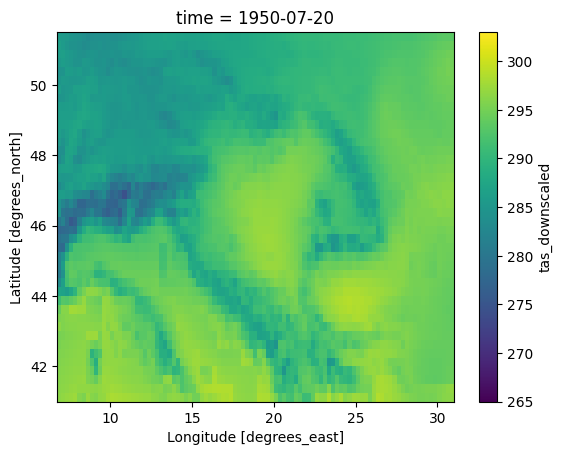

In [137]:
#Select the first time step
first_time_step = predicted_ds.isel(time=200).compute()  # Use .compute() if using Dask
first_time_step.plot(vmin=265, vmax=303)

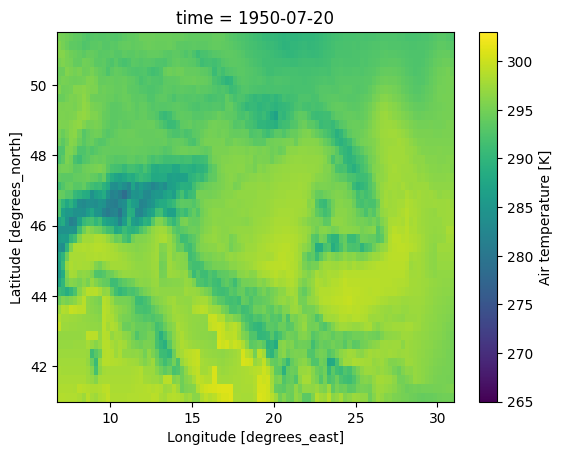

In [138]:
#Select the first time step
first_time_step = gmfd_data.isel(time=200).compute()  # Use .compute() if using Dask
first_time_step.tas.plot(vmin=265, vmax=303)

#### Scenario data

In [139]:
# Load the CMIP6 raw data (predictor variables)
cmip6_ssp245 = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp245/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_ssp245 = xr.open_zarr(cmip6_ssp245)
cmip6_sp245_high_res = cmip6_ssp245.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
# Get the mean and std from the training set for denormalization
cmip6_sp245_reshaped_min = cmip6_sp245_high_res['tas'].min().values
cmip6_sp245_reshaped_max = cmip6_sp245_high_res['tas'].max().values
cmip6_sp245_norm = normalize(cmip6_sp245_high_res['tas'])
cmip6_sp245_norm_reshaped = cmip6_sp245_norm.values[..., np.newaxis]


cmip6_sp245_psl = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp245/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp245_psl = xr.open_zarr(cmip6_sp245_psl)
cmip6_sp245_psl_high_res = cmip6_sp245_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})

cmip6_sp245_psl_norm = normalize(cmip6_sp245_psl_high_res['psl'])
cmip6_sp245_psl_reshaped = cmip6_sp245_psl_norm.values[..., np.newaxis]


# Concatenate the reshaped arrays along the last axis
cmip6_scen_combined = np.concatenate((cmip6_sp245_norm_reshaped, cmip6_sp245_psl_reshaped), axis=-1)

#### Perform the predictions on scenario data

In [140]:
# Predict downscaled high-resolution data
X_scen = np.expand_dims(cmip6_scen_combined, axis=1)

predicted_high_res = model_saved.predict(X_scen)

predicted_high_res = cmip6_sp245_norm_reshaped +  predicted_high_res[:,0,:,:]

# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res * (cmip6_sp245_reshaped_max- cmip6_sp245_reshaped_min) + cmip6_sp245_reshaped_min


982/982 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step


In [141]:
# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_sp245_high_res['tas'].shape)

# Save the predictions to a NetCDF file
predicted_ds = xr.DataArray(predicted_high_res_final, dims=cmip6_sp245_high_res['tas'].dims, coords=cmip6_sp245_high_res['tas'].coords, name='tas_downscaled')

predicted_ds.to_netcdf('/data/keeling/a/ad87/downscale/ncs/vit/predicted_high_res_tas_vit_ssp245.nc')

# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

Downscaled high-resolution predictions saved to NetCDF format.


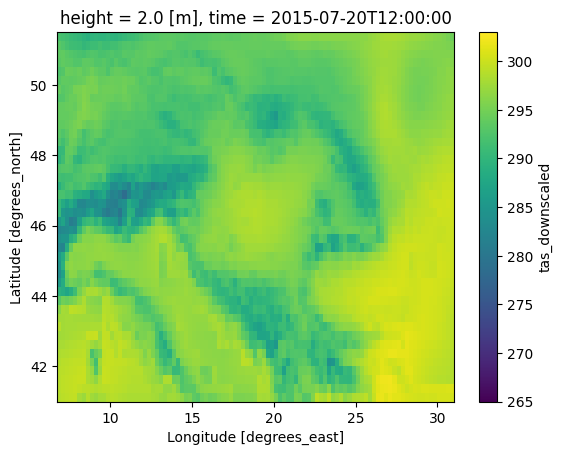

In [142]:
first_time_step = predicted_ds.isel(time=200).compute()  # Use .compute() if using Dask
first_time_step.plot(vmin=265, vmax=303)